<a href="https://colab.research.google.com/github/Ashraf-Al-Aodat/For-a-better-Intrusion-Detection-System-using-Deep-Learning-CIC2017-DB/blob/main/For_a_better_Intrusion_Detection_System_using_Deep_Learning_CIC2017_DB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download datasets..

!wget http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip
!unzip GeneratedLabelledFlows.zip
!mv 'TrafficLabelling ' IDS

!pip install swifter # install swifter for gpu pandas function processing


print('Initializing..')

import numpy as np
from numpy import unique
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error as mse, confusion_matrix as cm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import tensorflow as tf

#from tensorflow.python.keras.utils import plot_model
from tensorflow.python.keras.layers.merge import concatenate, Add
from tensorflow.python.keras.layers import Input, Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Lambda
from tensorflow.python.keras import Model, Sequential
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import tensorflow.python.keras.optimizers as opts
import tensorflow.keras.optimizers as opts_v2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import math


import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt


import sys
import os
import swifter

import matplotlib.pyplot as plt
import matplotlib as mpl

print('Done')

--2021-03-22 13:19:36--  http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip
Connecting to 205.174.165.80:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283876488 (271M) [application/zip]
Saving to: ‘GeneratedLabelledFlows.zip.2’

GeneratedLabelledFl 100%[===================>] 270.73M  5.42MB/s    in 82s     

2021-03-22 13:20:57 (3.32 MB/s) - ‘GeneratedLabelledFlows.zip.2’ saved [283876488/283876488]

Archive:  GeneratedLabelledFlows.zip
   creating: TrafficLabelling /
  inflating: TrafficLabelling /Wednesday-workingHours.pcap_ISCX.csv  
  inflating: TrafficLabelling /Tuesday-WorkingHours.pcap_ISCX.csv  
  inflating: TrafficLabelling /Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv  
  inflating: TrafficLabelling /Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv  
  inflating: TrafficLabelling /Monday-WorkingHours.pcap_ISCX.csv  
  inflating: TrafficLabelling /Friday-WorkingHours-Morning.pcap_ISCX.csv  
  inflatin

In [2]:
directory = "IDS"
files = os.listdir(directory)
df = pd.DataFrame()
for file in files:
    print('concat : ', file)
    if file.endswith('csv'):
      df = df.append(pd.read_csv(directory + "/" + file, low_memory=False, encoding = 'ISO-8859-1'))
      print('added')
data_set = df
df = None
data_set.reset_index(inplace=True,drop=True);
data_set.sample(frac=1).reset_index(drop=True);

concat :  Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
added
concat :  Monday-WorkingHours.pcap_ISCX.csv
added
concat :  Friday-WorkingHours-Morning.pcap_ISCX.csv
added
concat :  Tuesday-WorkingHours.pcap_ISCX.csv
added
concat :  Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
added
concat :  Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
added
concat :  Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
added
concat :  Wednesday-workingHours.pcap_ISCX.csv
added
concat :  TrafficLabelling 


In [3]:
print('Cleaning data..')
data_set = data_set.dropna()
data_set.reset_index(inplace=True,drop=True);
data_set.sample(frac=1).reset_index(drop=True);

#drop_same = pd.DataFrame([data_set.min(), data_set.max()]);
#drop_same.set_index(pd.Index(['min', 'max']), inplace=True)
#display(drop_same)

clean = data_set.drop([' Timestamp',' Bwd PSH Flags', ' Bwd URG Flags','Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'], axis=1)
data_set = None
flow_Id = clean[clean.columns[0]]
label = clean[clean.columns[len(clean.columns) - 1]]
clean = clean.drop([clean.columns[0], clean.columns[len(clean.columns) - 1]], axis=1)
categorical = clean.loc[:, clean.columns[0:5].tolist()]
continuous = clean.drop(categorical.columns, axis=1).swifter.apply(pd.to_numeric, axis=1, errors='coerce')
#continuous = clean.drop(categorical.columns, axis=1).apply(pd.to_numeric, axis=1, errors='coerce')
clean = pd.concat([categorical, continuous, flow_Id, label], axis=1)
with pd.option_context('mode.use_inf_as_na', True):
  clean = clean.dropna()
clean.reset_index(inplace=True,drop=True);
clean.sample(frac=1).reset_index(drop=True);
label = clean[clean.columns[len(clean.columns) - 1]]
flow_Id = clean[clean.columns[len(clean.columns) - 2]]
categorical = clean.loc[:, clean.columns[0:5].tolist()]
continuous = clean.loc[:, clean.columns[5:(len(clean.columns) - 2)]]
print('Done')

Cleaning data..



Done


In [4]:
# prepare target
def prepare_targets(data, binary):
  if binary: 
    data[data != 'BENIGN'] = 1
    data[data == 'BENIGN'] = 0
    return data
  else:
    label_encoder = LabelEncoder()
    label_encoder.fit(data)
    data = label_encoder.transform(data)
    return pd.Series(data)

# prepare categorical input data
def prepare_categorical_inputs(data):
	# label encode each column
	for index in range(data.shape[1]):
		label_encoder = LabelEncoder()
		label_encoder.fit(data.loc[:, data.columns[index]])
		# encode store
		data[data.columns[index]] = label_encoder.transform(data.loc[:, data.columns[index]].values)
		#data_test[data_test.columns[index]] = label_encoder.transform(data_test.loc[:, data_test.columns[index]].values)
	return data


def prepare_continuous_inputs(data, sl):
  #continuous values normalization
  columns = data.columns
  index = data.index[0]
  if sl:
    standard_scaler = StandardScaler()
    standard_scaler.fit(data)
    data = standard_scaler.transform(data)
  else:
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(data)
    data = min_max_scaler.transform(data)

  data = pd.DataFrame(data, columns=columns)
  data.index += index
  return data

# prepare slice function for keras layers.
def crop(dim=1, start=0,end=1):
	def func(x):
		if dim == 0:
			return x[start: end]
		if dim == 1:
			return x[:, start: end]
		if dim == 2:
			return x[:, :, start: end]
		if dim == 3:
			return x[:, :, :, start: end]
		if dim == 4:
			return x[:, :, :, :, start: end]
	return Lambda(func)

In [5]:
# dataset spliting test and train.
# without flow id
y = prepare_targets(label.copy(), True).astype('float32')

x = pd.concat([prepare_categorical_inputs(categorical).astype('float32'),
               prepare_continuous_inputs(continuous, False).astype('float32')], axis=1)

x_categorical_columns = categorical.columns

x_continuous_columns = continuous.columns


folds = []
for train_index, test_index in StratifiedKFold(n_splits=5).split(x, y):
  folds.append([train_index, test_index])

In [97]:
def plot_history(history, epochs=50):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

def show_con(model, x, y, classes, pred, num=True, fontsize=10, figsize= 10):

  con_mat = tf.math.confusion_matrix(labels=y.astype(np.int64), predictions=pred).numpy()

  figure = plt.figure(figsize=(figsize, figsize))

  if num:
    fmt = 'g'
  else:
    fmt = '.0%' 
    con_mat = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(con_mat, index = classes, columns = classes)

  sns.heatmap(con_mat_df, annot=True, fmt=fmt,cmap=plt.cm.Blues)
  
  fontsize = fontsize
  plt.yticks(rotation=0, fontsize=fontsize, fontweight='bold')
  plt.xticks(rotation=0, fontsize=fontsize, fontweight='bold')
  plt.ylabel('True label', fontsize=fontsize, fontweight='bold')
  plt.xlabel('Predicted label', fontsize=fontsize, fontweight='bold')
  plt.show()

def get_callbacks(patience_lr):
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-5, mode='min')
    learningRateScheduler = LearningRateScheduler(schedulerExp)
    earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5)
    return [reduce_lr_loss, learningRateScheduler]#, earlyStopping]


def schedulerExp(epoch, lr):
    return lr * tf.math.exp(-0.1)

def schedulerStep(epoch, lr):
  return lr * tf.math.pow(0.5, tf.math.floor((1+epoch) / 10.0))

# build classification model.

def build_model(epochs=50):
  input = Input((74,))
  embedding_layers = []
  for index in range(len(x_categorical_columns)):
    labels_length = len(unique(x[x_categorical_columns[index]]))
    dim = round(math.pow(labels_length, 1/4)) + 1
    s = crop(1, index, index+1)(input)
    embedding_layer = Embedding(output_dim=dim, input_dim=labels_length, input_length=1)(s)
    embedding_layer = Reshape((dim,))(embedding_layer)
    embedding_layers.append(embedding_layer)

  embedding_layers.append(crop(1, 5, 74)(input))
  em = Concatenate()(embedding_layers)

  l = Dense(128, activation='relu')(em)
  l = Dropout(0.25)(l)
  l = Dense(64, activation='relu')(l)
  l = Dropout(0.50)(l)
  l = Dense(32, activation='relu')(l)
  
  
  output = Dense(len(y.unique())-1, activation='sigmoid')(l)
  
  lr = 1e-3 

  opt = tf.keras.optimizers.Adam(lr=lr, decay=lr / epochs)
  loss = loss=tf.keras.losses.BinaryCrossentropy(from_logits=True)

  model = tf.keras.models.Model(inputs=input, outputs=output)
  model.compile(opt, loss, metrics=["accuracy"])
  
  return model

def fit_model(model, x_train_cv, y_train_cv, x_valid_cv, y_valid_cv, batch_size= 50, epochs= 50):
  
  callbacks = get_callbacks(patience_lr=5)
  history = model.fit(x=x_train_cv, y=y_train_cv, steps_per_epoch=len(x_train_cv) / batch_size, epochs=epochs,
                      batch_size=batch_size, shuffle=True, verbose=1,
                      validation_data = (x_valid_cv, y_valid_cv), callbacks = callbacks)
  return history


In [98]:
model = build_model()
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 74)]         0                                            
__________________________________________________________________________________________________
lambda_48 (Lambda)              (None, 1)            0           input_9[0][0]                    
__________________________________________________________________________________________________
lambda_49 (Lambda)              (None, 1)            0           input_9[0][0]                    
__________________________________________________________________________________________________
lambda_50 (Lambda)              (None, 1)            0           input_9[0][0]                    
____________________________________________________________________________________________


Fold  0
                   
Epoch 1/50
10/10 [==============================] - 19s 2s/step - loss: 0.6436 - accuracy: 0.6564 - val_loss: 0.4892 - val_accuracy: 0.8032
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.4794 - accuracy: 0.8032 - val_loss: 0.4035 - val_accuracy: 0.8032
Epoch 3/50
10/10 [==============================] - 16s 2s/step - loss: 0.4024 - accuracy: 0.8116 - val_loss: 0.3364 - val_accuracy: 0.8505
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.3254 - accuracy: 0.8613 - val_loss: 0.2459 - val_accuracy: 0.9027
Epoch 5/50
10/10 [==============================] - 16s 2s/step - loss: 0.2272 - accuracy: 0.8929 - val_loss: 0.1366 - val_accuracy: 0.9572
Epoch 6/50
10/10 [==============================] - 16s 2s/step - loss: 0.1300 - accuracy: 0.9662 - val_loss: 0.0674 - val_accuracy: 0.9966
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.0695 - accuracy: 0.9937 - val_loss: 0.0341 - val_accuracy

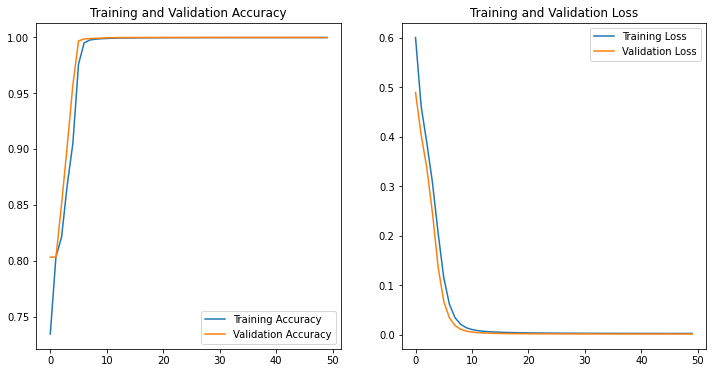

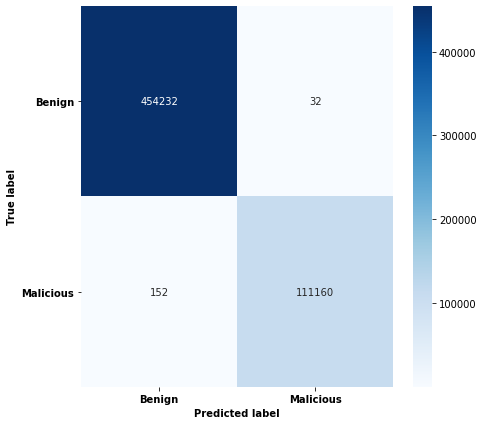

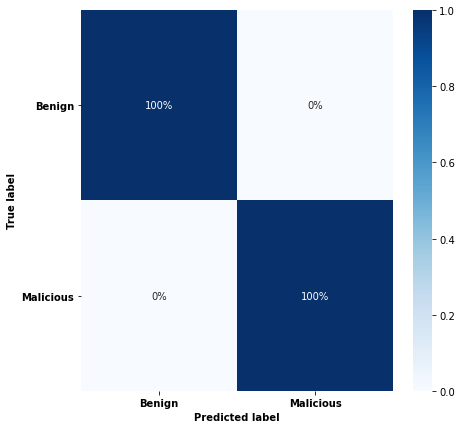


Fold  1
                   
Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.5940 - accuracy: 0.7776 - val_loss: 0.4478 - val_accuracy: 0.8032
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.4571 - accuracy: 0.8054 - val_loss: 0.3509 - val_accuracy: 0.8700
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.3811 - accuracy: 0.8381 - val_loss: 0.2690 - val_accuracy: 0.8846
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.2941 - accuracy: 0.8683 - val_loss: 0.1594 - val_accuracy: 0.8995
Epoch 5/50
10/10 [==============================] - 18s 2s/step - loss: 0.1867 - accuracy: 0.9137 - val_loss: 0.0766 - val_accuracy: 0.9939
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.1005 - accuracy: 0.9808 - val_loss: 0.0368 - val_accuracy: 0.9986
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.0532 - accuracy: 0.9951 - val_loss: 0.0186 - val_accuracy

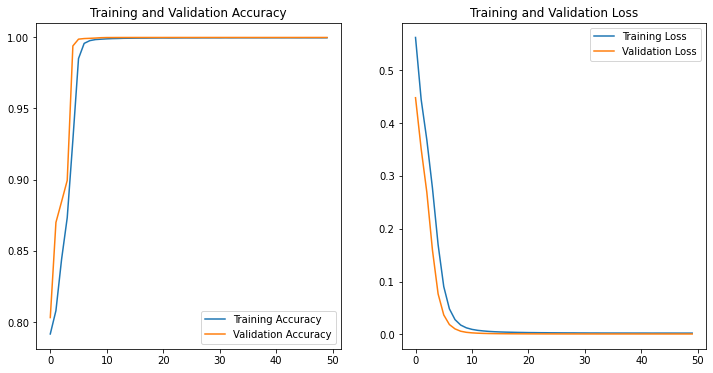

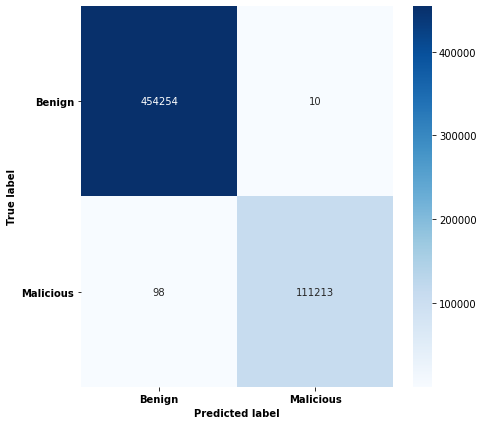

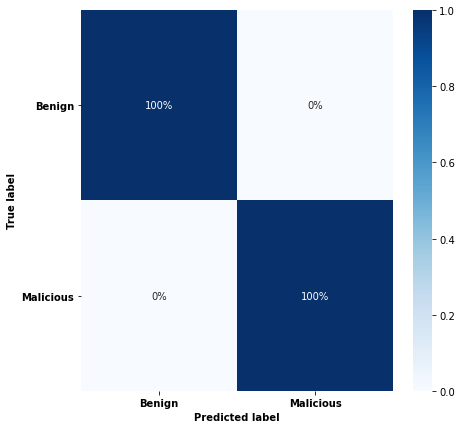


Fold  2
                   
Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.6387 - accuracy: 0.6967 - val_loss: 0.5032 - val_accuracy: 0.8032
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.4990 - accuracy: 0.8056 - val_loss: 0.4043 - val_accuracy: 0.8337
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.4144 - accuracy: 0.8273 - val_loss: 0.3229 - val_accuracy: 0.8743
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.3364 - accuracy: 0.8610 - val_loss: 0.2460 - val_accuracy: 0.8919
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.2501 - accuracy: 0.8852 - val_loss: 0.1447 - val_accuracy: 0.9027
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.1534 - accuracy: 0.9441 - val_loss: 0.0684 - val_accuracy: 0.9948
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.0851 - accuracy: 0.9900 - val_loss: 0.0357 - val_accuracy

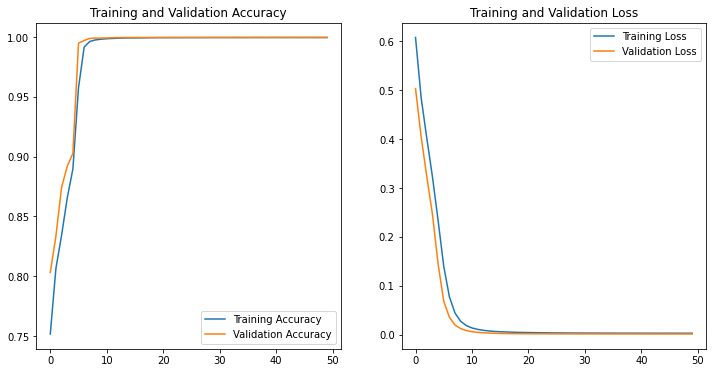

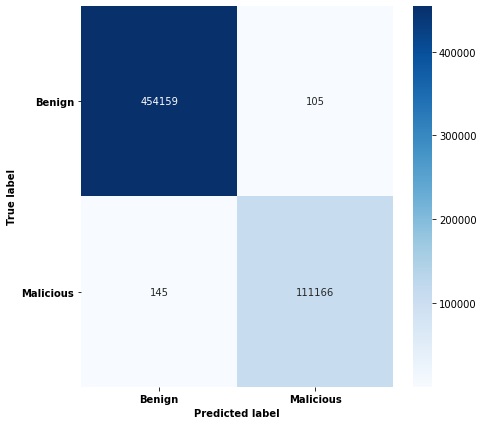

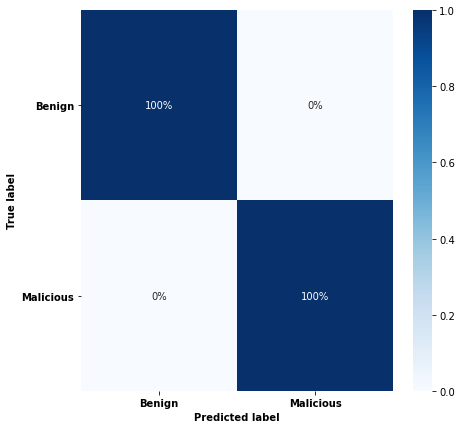


Fold  3
                   
Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.6375 - accuracy: 0.7171 - val_loss: 0.5188 - val_accuracy: 0.8032
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.4882 - accuracy: 0.8032 - val_loss: 0.4055 - val_accuracy: 0.8032
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.4059 - accuracy: 0.8030 - val_loss: 0.3338 - val_accuracy: 0.8033
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.3302 - accuracy: 0.8085 - val_loss: 0.2565 - val_accuracy: 0.8686
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.2440 - accuracy: 0.8343 - val_loss: 0.1741 - val_accuracy: 0.8935
Epoch 6/50
10/10 [==============================] - 18s 2s/step - loss: 0.1692 - accuracy: 0.9000 - val_loss: 0.1228 - val_accuracy: 0.9943
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.1222 - accuracy: 0.9739 - val_loss: 0.0900 - val_accuracy

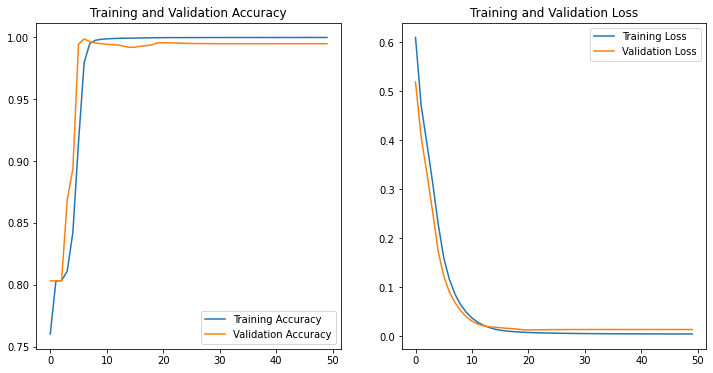

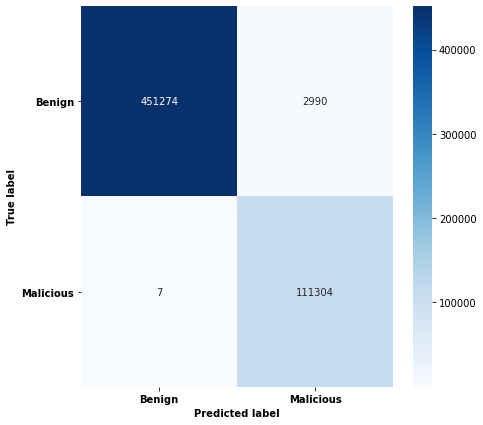

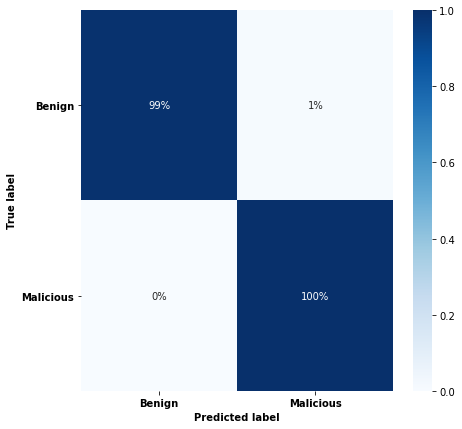


Fold  4
                   
Epoch 1/50
10/10 [==============================] - 20s 2s/step - loss: 0.5893 - accuracy: 0.7888 - val_loss: 0.4624 - val_accuracy: 0.8032
Epoch 2/50
10/10 [==============================] - 17s 2s/step - loss: 0.4575 - accuracy: 0.8045 - val_loss: 0.4047 - val_accuracy: 0.8428
Epoch 3/50
10/10 [==============================] - 18s 2s/step - loss: 0.3834 - accuracy: 0.8344 - val_loss: 0.3192 - val_accuracy: 0.8576
Epoch 4/50
10/10 [==============================] - 17s 2s/step - loss: 0.2939 - accuracy: 0.8716 - val_loss: 0.2046 - val_accuracy: 0.8699
Epoch 5/50
10/10 [==============================] - 17s 2s/step - loss: 0.1931 - accuracy: 0.9092 - val_loss: 0.1104 - val_accuracy: 0.9909
Epoch 6/50
10/10 [==============================] - 17s 2s/step - loss: 0.1148 - accuracy: 0.9758 - val_loss: 0.0630 - val_accuracy: 0.9973
Epoch 7/50
10/10 [==============================] - 17s 2s/step - loss: 0.0669 - accuracy: 0.9942 - val_loss: 0.0369 - val_accuracy

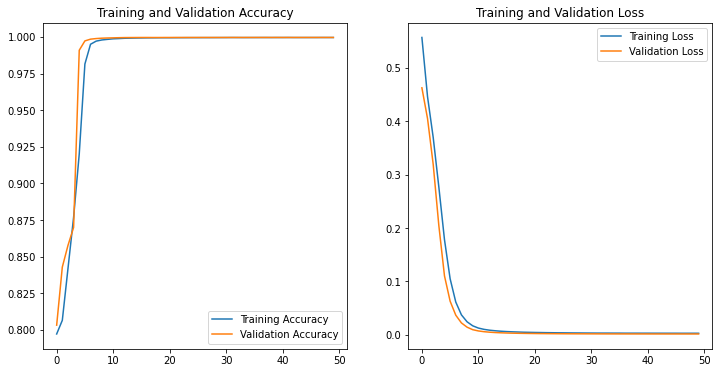

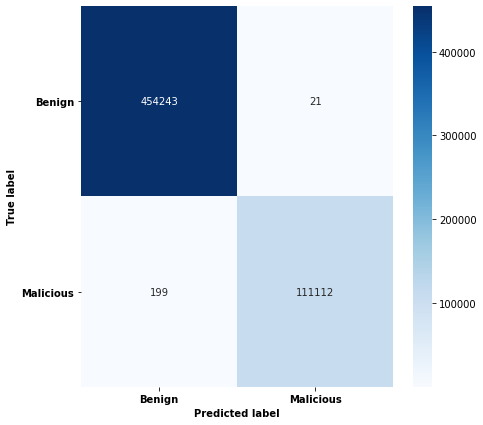

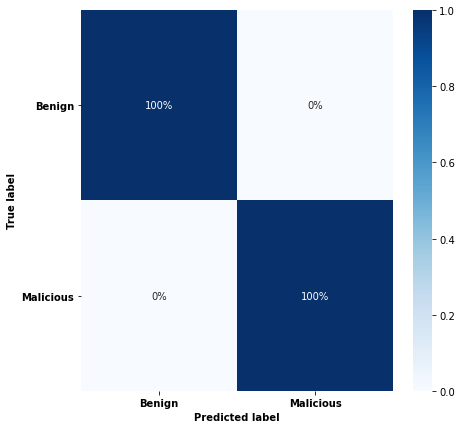

5 Fold Cv Avg:  0.9986707334395375 List: [0.9996746679491351, 0.9998090438933829, 0.9995579719754233, 0.9947009680413739, 0.9996110153383725]


In [101]:
#fold 5

start = 1
end = 5

cv_sum = 0;

cv_acc_list = []

#with open('folds.npy', 'rb') as f:
#  import numpy as np
#  folds = np.load(f, allow_pickle=True)

for i in range(start-1, end):
  print('\nFold ',i)
  print('                   ')

  x_train_cv = x.loc[folds[i][0]]
  y_train_cv = y.loc[folds[i][0]]
  x_test_cv = x.loc[folds[i][1]]
  y_test_cv= y.loc[folds[i][1]]
  model = build_model()

  plot_model(model)
  history = fit_model(model, x_train_cv, y_train_cv, x_test_cv, y_test_cv, batch_size=int(x_train_cv.shape[0] / 10))

  pred = model.predict(x_test_cv)

  acc = accuracy_score(y_test_cv, pred.round().astype(np.int32))
  cv_acc_list.append(acc)
  print('CV Evaluate:', model.evaluate(x_test_cv, y_test_cv))
  cv_sum = cv_sum + acc 

  plot_history(history)
  
  show_con(model, x_test_cv, y_test_cv, ['Benign','Malicious'], pred.round(), True, 10, 7)
  show_con(model, x_test_cv, y_test_cv, ['Benign','Malicious'], pred.round(), False, 10, 7)

  with open('/content/drive/MyDrive/IDS_' + '_fold_'+ str(i) +'.npy', 'wb') as f:
    import numpy as np  
    np.save(f, history.history, allow_pickle=True)

print('5 Fold Cv Avg: ', cv_sum / 5, 'List:', cv_acc_list)

In [173]:
historys = []
for i in range(5):
  import numpy as np  
  historys.append(np.load('/content/drive/MyDrive/IDS__fold_' + str(i) + '.npy', allow_pickle=True).tolist())

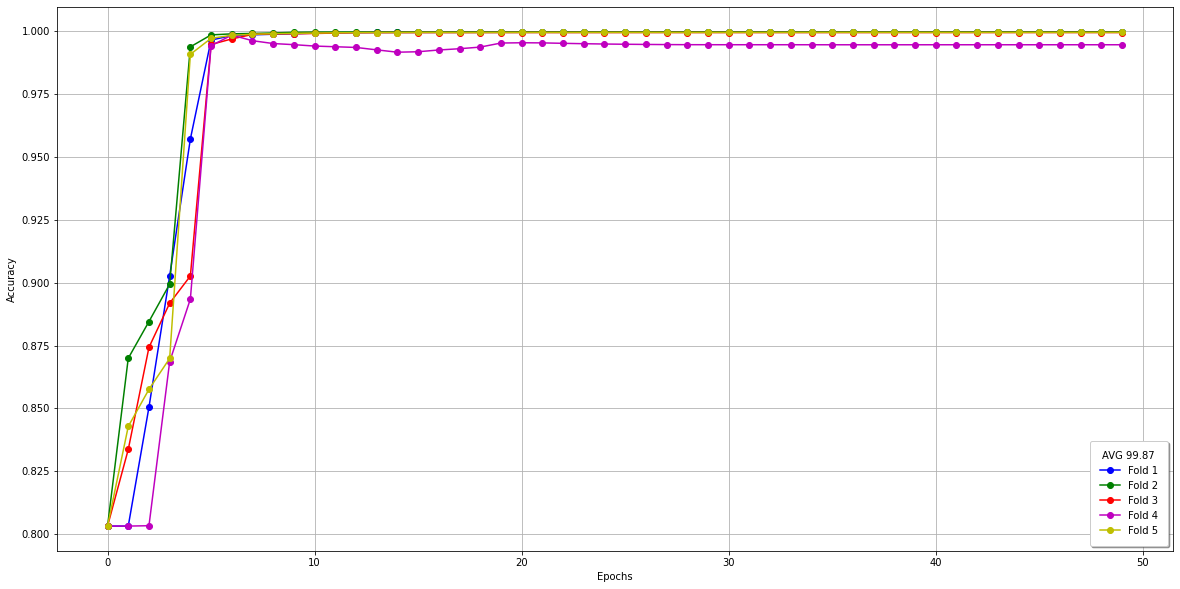

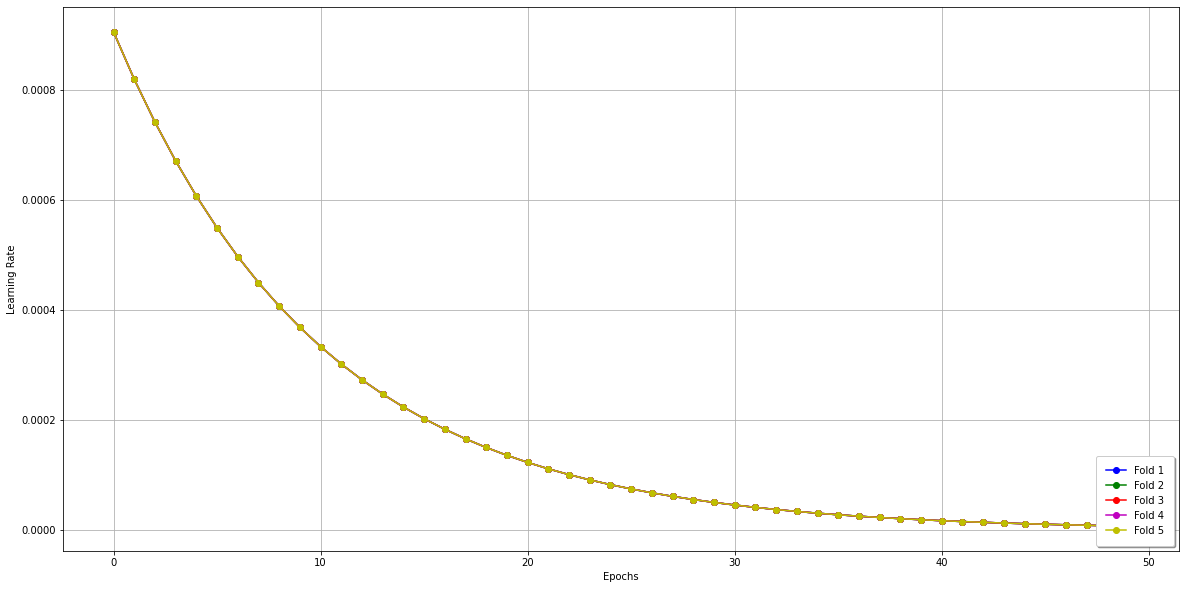

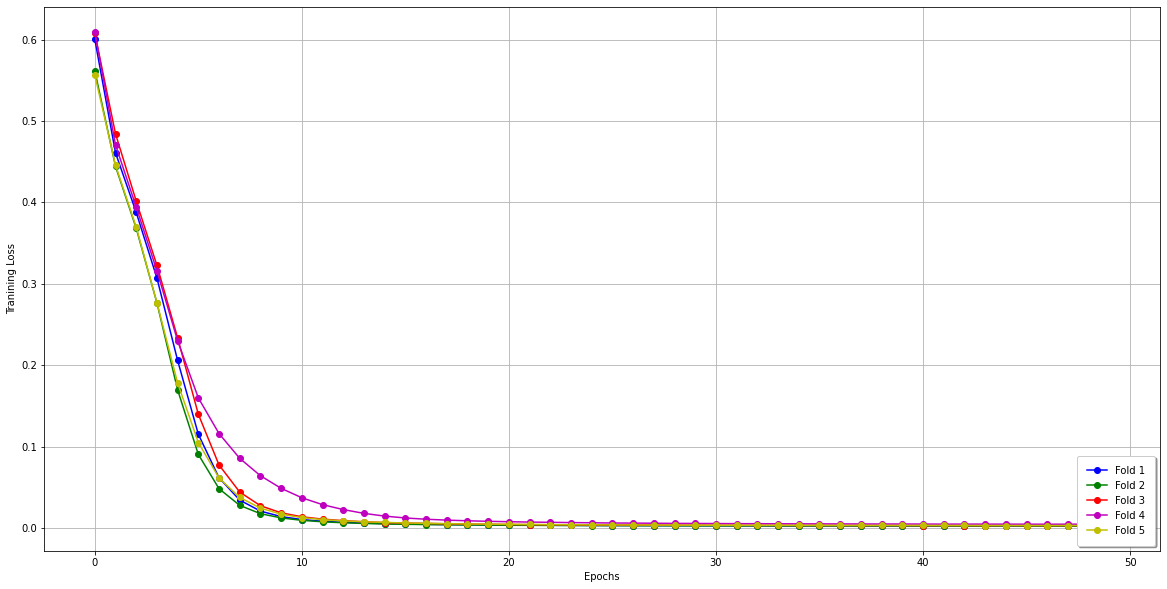

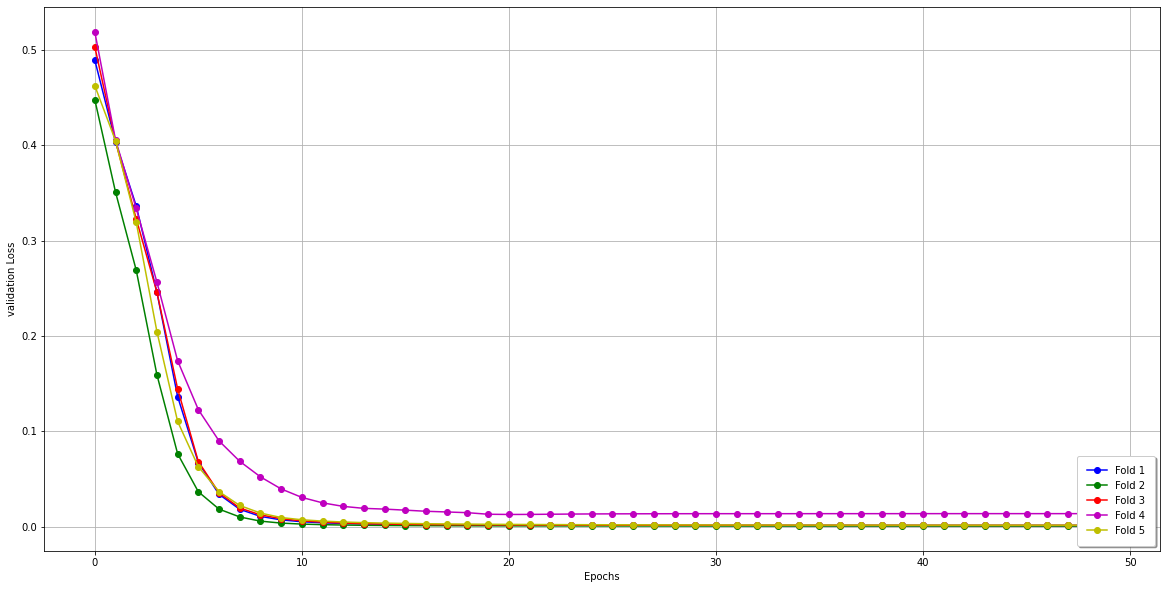

In [172]:
import numpy as np
import cv2
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

def plot_folds_history_acc(historys):

  val_accuracy_1 = historys[0]['val_accuracy']
  val_accuracy_2 = historys[1]['val_accuracy']
  val_accuracy_3 = historys[2]['val_accuracy']
  val_accuracy_4 = historys[3]['val_accuracy']
  val_accuracy_5 = historys[4]['val_accuracy']
  
  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(val_accuracy_1, 'ob')
  plt.plot(val_accuracy_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(val_accuracy_2, 'og')
  plt.plot(val_accuracy_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(val_accuracy_3, 'or')
  plt.plot(val_accuracy_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(val_accuracy_4, 'om')
  plt.plot(val_accuracy_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(val_accuracy_5, 'oy')
  plt.plot(val_accuracy_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True)

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], title='AVG ' + str(round(cv_sum / 5 * 100, 2)), framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
    
  plt.show()


def plot_folds_history_lr(historys):

  lr_1 = historys[0]['lr']
  lr_2 = historys[1]['lr']
  lr_3 = historys[2]['lr']
  lr_4 = historys[3]['lr']
  lr_5 = historys[4]['lr']

  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(lr_1, 'ob')
  plt.plot(lr_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(lr_2, 'og')
  plt.plot(lr_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(lr_3, 'or')
  plt.plot(lr_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(lr_4, 'om')
  plt.plot(lr_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(lr_5, 'oy')
  plt.plot(lr_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True) 

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Learning Rate')
    
  plt.show()


def plot_folds_history_loss(historys):

  loss_1 = historys[0]['loss']
  loss_2 = historys[1]['loss']
  loss_3 = historys[2]['loss']
  loss_4 = historys[3]['loss']
  loss_5 = historys[4]['loss']


  epochs_range = range(50)

  plt.figure(figsize=(20, 10))

  plt.grid(True) 
  
  plt.plot(loss_1, 'ob')
  plt.plot(loss_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(loss_2, 'og')
  plt.plot(loss_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(loss_3, 'or')
  plt.plot(loss_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(loss_4, 'om')
  plt.plot(loss_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(loss_5, 'oy')
  plt.plot(loss_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('Tranining Loss')
    
  plt.show()

def plot_folds_history_loss_val(historys):

  val_loss_1 = historys[0]['val_loss']
  val_loss_2 = historys[1]['val_loss']
  val_loss_3 = historys[2]['val_loss']
  val_loss_4 = historys[3]['val_loss']
  val_loss_5 = historys[4]['val_loss']

  epochs_range = range(50)

  plt.figure(figsize=(20, 10))
    
  plt.plot(val_loss_1, 'ob')
  plt.plot(val_loss_1, 'b')
  b_circle_line = mlines.Line2D([], [], color='b', marker='o', label='Fold 1')

  plt.plot(val_loss_2, 'og')
  plt.plot(val_loss_2, 'g')
  g_circle_line = mlines.Line2D([], [], color='g', marker='o', label='Fold 2')
    
  plt.plot(val_loss_3, 'or')
  plt.plot(val_loss_3, 'r')
  r_circle_line = mlines.Line2D([], [], color='r', marker='o', label='Fold 3')

  plt.plot(val_loss_4, 'om')
  plt.plot(val_loss_4, 'm')
  m_circle_line = mlines.Line2D([], [], color='m', marker='o', label='Fold 4')

  plt.plot(val_loss_5, 'oy')
  plt.plot(val_loss_5, 'y')
  y_circle_line = mlines.Line2D([], [], color='y', marker='o', label='Fold 5')

  plt.grid(True) 

  plt.legend(loc='lower right', handles=[b_circle_line, g_circle_line, r_circle_line, m_circle_line, y_circle_line], framealpha=1, shadow=True, borderpad=1)
  plt.xlabel('Epochs')
  plt.ylabel('validation Loss')
    
  plt.show()


plot_folds_history_acc(historys)
plot_folds_history_lr(historys)
plot_folds_history_loss(historys)
plot_folds_history_loss_val(historys)